In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandahouse
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## Задание
В наших данных использования приложения ленты новостей 
есть два типа пользователей: те, кто пришел через платный трафик source = 'ads', и те, кто пришел через органические каналы source = 'organic'.
**Наша цель — проанализировать и сравнить Retention и Churn Rate этих двух групп пользователей. Ответить на вопрос отличается ли характер использования приложения у этих групп пользователей.** Рассматриваемый период когорт будет равный 31 день.
* первая когорта - 2023-12-29 г.
* последняя когорта - 2024-01-28 г.

## Пользователи пришедшие в приложение через платный трафик

In [2]:
# для начала подключимся к нашей базе данных, в которой отберем пользователей, которые пришли в наше приложение через платные трафики

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q ="""
select date as date, start_date as start_date, count(user_id) as active_users
from (select user_id, min(toDate(time)) as start_date from simulator_20240120.feed_actions
where source = 'ads' 
group by user_id 
having start_date >= today() - 30) t1 
join
(select distinct user_id, toDate(time) as date 
from simulator_20240120.feed_actions
where source = 'ads') t2 
using user_id 
group by date, start_date
"""

df_ads = pandahouse.read_clickhouse(q, connection=connection)

df_ads.head()

,date,start_date,active_users
0,2024-01-22,2024-01-17,288
1,2024-01-25,2024-01-13,146
2,2024-01-26,2024-01-23,309
3,2024-01-27,2024-01-05,25
4,2024-01-09,2024-01-05,68


In [3]:
#переведём колонки с датами в нужный формат, для более удобного отображения на графики в дальнейшем

df_ads['date'] = df_ads['date'].dt.to_period('D')
df_ads['start_date'] = df_ads['start_date'].dt.to_period('D')

построим сводную таблицу для когортного анализа по дням, за последний месяц

In [4]:
df_cohort_ads = df_ads.pivot_table(columns='date', index = 'start_date',values='active_users')

In [5]:
df_cohort_ads.head()

date,2023-12-29,2023-12-30,2023-12-31,2024-01-01,2024-01-02,2024-01-03,2024-01-04,2024-01-05,2024-01-06,2024-01-07,...,2024-01-19,2024-01-20,2024-01-21,2024-01-22,2024-01-23,2024-01-24,2024-01-25,2024-01-26,2024-01-27,2024-01-28
start_date,,,,,,,,,,,,,,,,,,,,,
2023-12-29,952.0,237.0,226.0,234.0,228.0,199.0,214.0,192.0,183.0,167.0,...,78.0,36.0,55.0,49.0,58.0,55.0,61.0,64.0,50.0,52.0
2023-12-30,NaN,1229.0,423.0,383.0,401.0,377.0,370.0,364.0,370.0,279.0,...,123.0,90.0,112.0,89.0,104.0,102.0,94.0,85.0,102.0,82.0
2023-12-31,NaN,NaN,1247.0,480.0,414.0,411.0,437.0,431.0,415.0,380.0,...,138.0,100.0,141.0,127.0,122.0,125.0,114.0,103.0,102.0,112.0
2024-01-01,NaN,NaN,NaN,1304.0,585.0,499.0,473.0,462.0,439.0,413.0,...,150.0,133.0,151.0,134.0,135.0,115.0,131.0,117.0,99.0,101.0
2024-01-02,NaN,NaN,NaN,NaN,1180.0,495.0,461.0,412.0,362.0,363.0,...,151.0,123.0,118.0,121.0,113.0,117.0,115.0,100.0,99.0,83.0


In [6]:
#отберем абсолютные значения периода старта для каждой когорты

values_ads = np.diag(df_cohort_ads)
values_ads

array([ 952., 1229., 1247., 1304., 1180., 1193.,  374.,  430.,  899.,
       1005., 1116.,  902.,  946., 2592.,  393.,  823.,  947., 1080.,
        783.,  878.,  701.,  639., 1409., 1100.,  846.,  964., 1040.,
        734.,  662., 1098., 1063.])

In [7]:
#переведём в процентное соотношение, которое отражает отток пользователей по дням

df_percentage_ads=df_cohort_ads.div(values_ads,axis=0)

In [8]:
df_percentage_ads.head()

date,2023-12-29,2023-12-30,2023-12-31,2024-01-01,2024-01-02,2024-01-03,2024-01-04,2024-01-05,2024-01-06,2024-01-07,...,2024-01-19,2024-01-20,2024-01-21,2024-01-22,2024-01-23,2024-01-24,2024-01-25,2024-01-26,2024-01-27,2024-01-28
start_date,,,,,,,,,,,,,,,,,,,,,
2023-12-29,1.0,0.24895,0.237395,0.245798,0.239496,0.209034,0.224790,0.201681,0.192227,0.175420,...,0.081933,0.037815,0.057773,0.051471,0.060924,0.057773,0.064076,0.067227,0.052521,0.054622
2023-12-30,NaN,1.00000,0.344182,0.311635,0.326282,0.306753,0.301058,0.296176,0.301058,0.227014,...,0.100081,0.073230,0.091131,0.072417,0.084622,0.082994,0.076485,0.069162,0.082994,0.066721
2023-12-31,NaN,NaN,1.000000,0.384924,0.331997,0.329591,0.350441,0.345630,0.332799,0.304731,...,0.110666,0.080192,0.113071,0.101844,0.097835,0.100241,0.091419,0.082598,0.081796,0.089816
2024-01-01,NaN,NaN,NaN,1.000000,0.448620,0.382669,0.362730,0.354294,0.336656,0.316718,...,0.115031,0.101994,0.115798,0.102761,0.103528,0.088190,0.100460,0.089724,0.075920,0.077454
2024-01-02,NaN,NaN,NaN,NaN,1.000000,0.419492,0.390678,0.349153,0.306780,0.307627,...,0.127966,0.104237,0.100000,0.102542,0.095763,0.099153,0.097458,0.084746,0.083898,0.070339


<Axes: title={'center': 'Когортный анализ пользователей пришедших через платный трафик'}, xlabel='date', ylabel='start_date'>

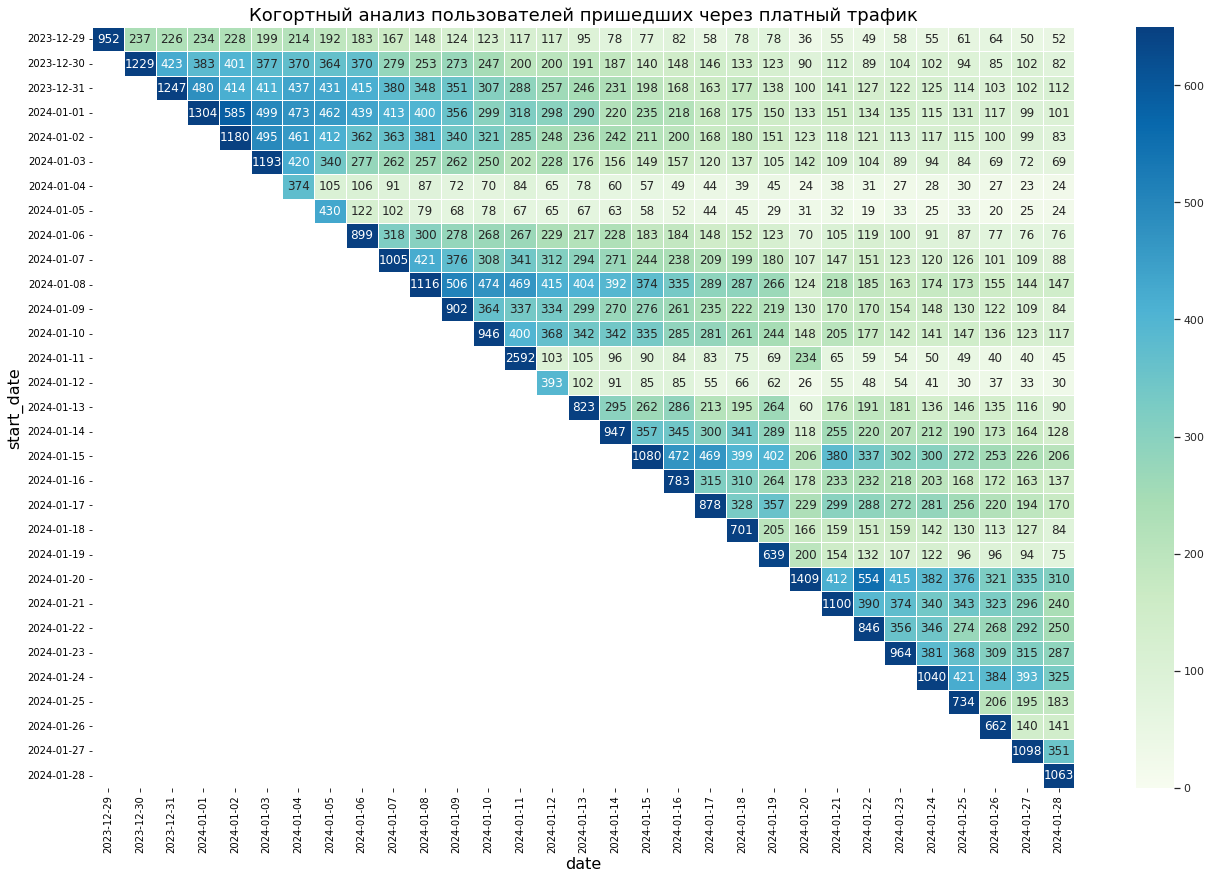

In [9]:
plt.figure(figsize = (22,14))
plt.rcParams['axes.titlesize'] = 18
plt.xlabel('xlabel', fontsize=16)
plt.ylabel('ylabel', fontsize=16)
plt.title('Когортный анализ пользователей пришедших через платный трафик')
sns.set(font='sans-serif')
sns.heatmap(df_cohort_ads, annot=True, fmt = '.0f', vmin=0, vmax=650, cmap='GnBu', linewidths = 1, linecolor = "white")

<Axes: title={'center': 'Процент оттока пользователей пришедших через платный трафик'}, xlabel='date', ylabel='start_date'>

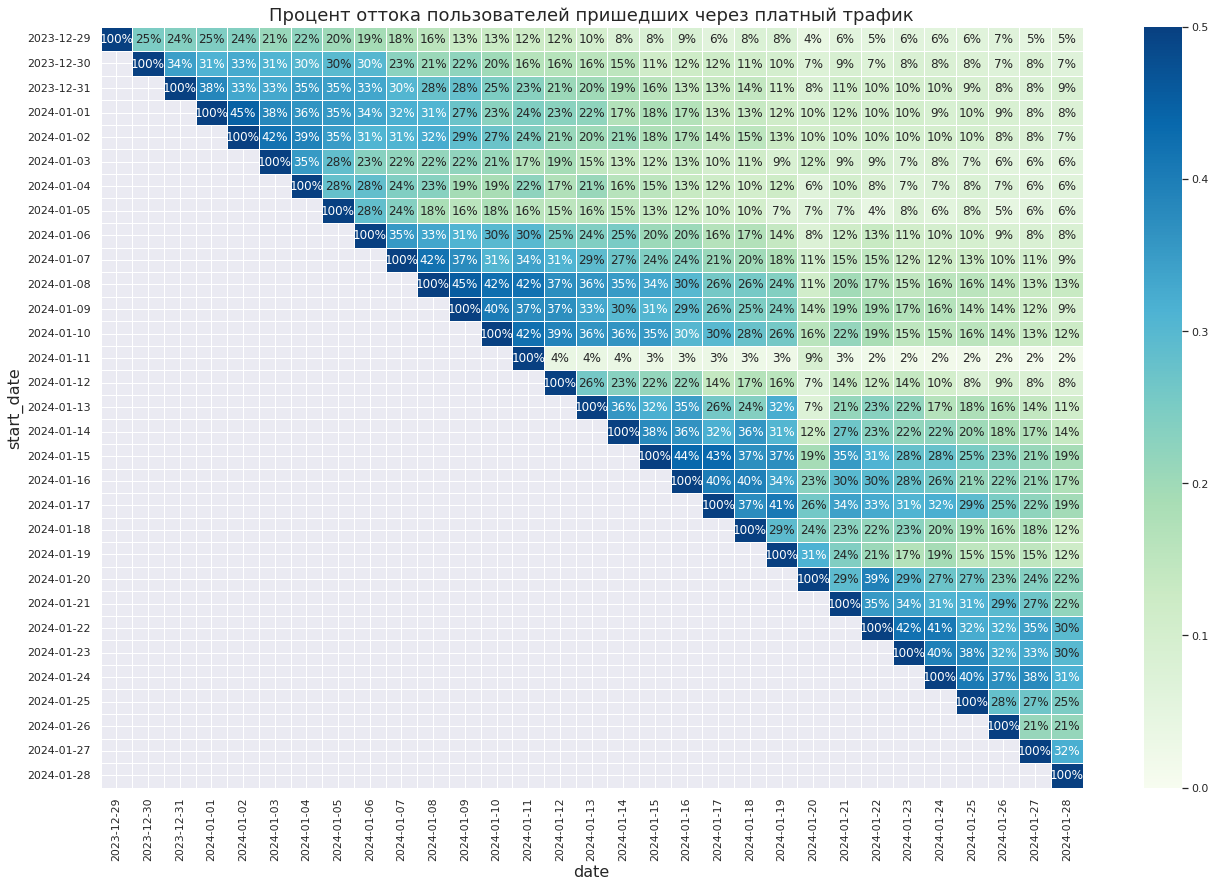

In [10]:
#построим график

plt.figure(figsize = (22,14))
plt.rcParams['axes.titlesize'] = 18
plt.xlabel('xlabel', fontsize=16)
plt.ylabel('ylabel', fontsize=16)
plt.title('Процент оттока пользователей пришедших через платный трафик')
sns.set(font='sans-serif')
sns.heatmap(df_percentage_ads, annot=True, fmt = '.0%', vmin=0, vmax=0.5, cmap='GnBu', linewidths = 1, linecolor = "white")

## Выводы по рекламному трафику:

1. Пользователи пришедшие в приложение через платные трафики имеют большой процент оттока из приложения, так когорта 2023-12-29 (952 пользователя), о которой мы распалагаем наибольшей информацией, на следующий день вернулось в приложение 237 человек, что составляет 25 процеетов от предыдущего дня, а на конец периода расчёта 2024-01-28, в приложение вернулось 35 человек, что составляет 4% от изначального числа пользователей. 
2. Когорта 2024-01-11 с наибольшим количеством 2592 пользователя, на следующий день вернулось 103 пользователя, что составляет 4 процента от предыдущего дня, а на конец пириода расчёта только 30 человек из когорты продолжили пользоваться приложением. 
3. В 100% случаев отток пользователей на следующий день составил более 50%
4. Поработать с пользователями, которые склонны к пользованию приложением каждый день, уточнить причины, приемущества, собрать отзывы.
5. Также проанализировать причину отказа пользователей от использования приложения, провести опросы, удобгный ли продукт для использования, прост или сложен в использовании. 

## Пользователи пришедшие через органический трафик

In [11]:
# повторим запрос к базе данных, только отберём пользователей, которые пришли в приложение через органический трафик

q_organic ="""
select date as date, start_date as start_date, count(user_id) as active_users
from (select user_id, min(toDate(time)) as start_date from simulator_20240120.feed_actions
where source = 'organic' 
group by user_id 
having start_date >= today() - 30) t1 
join
(select distinct user_id, toDate(time) as date 
from simulator_20240120.feed_actions
where source = 'organic') t2 
using user_id 
group by date, start_date
"""

df_organic = pandahouse.read_clickhouse(q_organic, connection=connection)

df_organic.head()

,date,start_date,active_users
0,2024-01-22,2024-01-17,443
1,2024-01-25,2024-01-13,228
2,2024-01-26,2024-01-23,514
3,2024-01-27,2024-01-05,57
4,2024-01-09,2024-01-05,129


In [12]:
#переведём колонки с датами в нужный формат, для более удобного отображения на графики в дальнейшем

df_organic['date'] = df_organic['date'].dt.to_period('D')
df_organic['start_date'] = df_organic['start_date'].dt.to_period('D')

построим сводную таблицу для когортного анализа по дням, за последний месяц

In [13]:
df_cohortorganic = df_organic.pivot_table(columns='date', index = 'start_date',values='active_users')

In [14]:
#отберем абсолютные значения периода старта для каждой когорты

values_col_organic = np.diag(df_cohortorganic)

In [15]:
#переведём в процентное соотношение, которое отражает отток пользователей по дням

df_percentage_organic=df_cohortorganic.div(values_col_organic, axis=0)

<Axes: title={'center': 'Когортный анализ пользователей пришедших через органический трафик'}, xlabel='date', ylabel='start_date'>

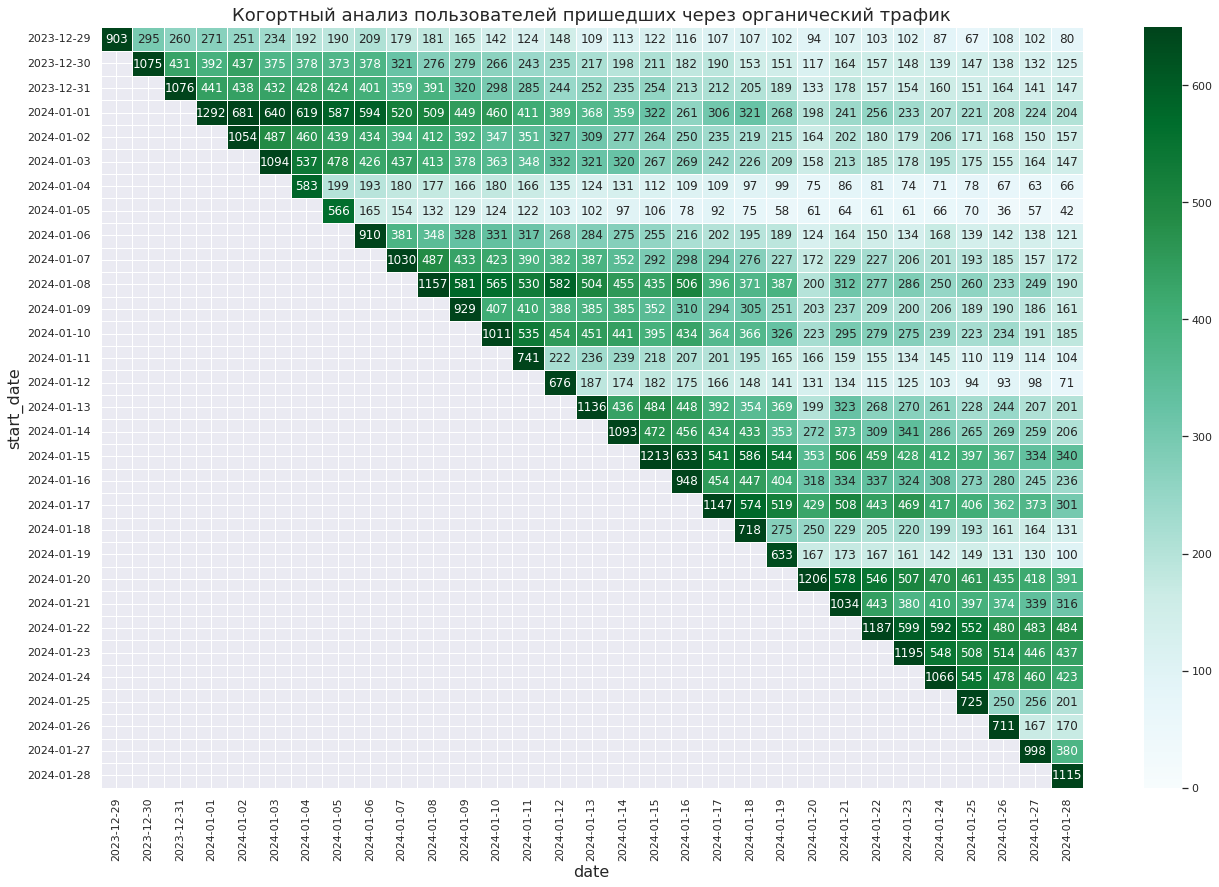

In [16]:
#построим график

plt.figure(figsize = (22,14))
plt.rcParams['axes.titlesize'] = 18
plt.xlabel('xlabel', fontsize=16)
plt.ylabel('ylabel', fontsize=16)
plt.title('Когортный анализ пользователей пришедших через органический трафик')
sns.set(font='sans-serif')
sns.heatmap(df_cohortorganic, annot=True, fmt = '.0f', vmin=0, vmax=650, cmap='BuGn', linewidths = 1, linecolor = "white")

<Axes: title={'center': 'Процент оттока пользователей пришедших органическим путем'}, xlabel='date', ylabel='start_date'>

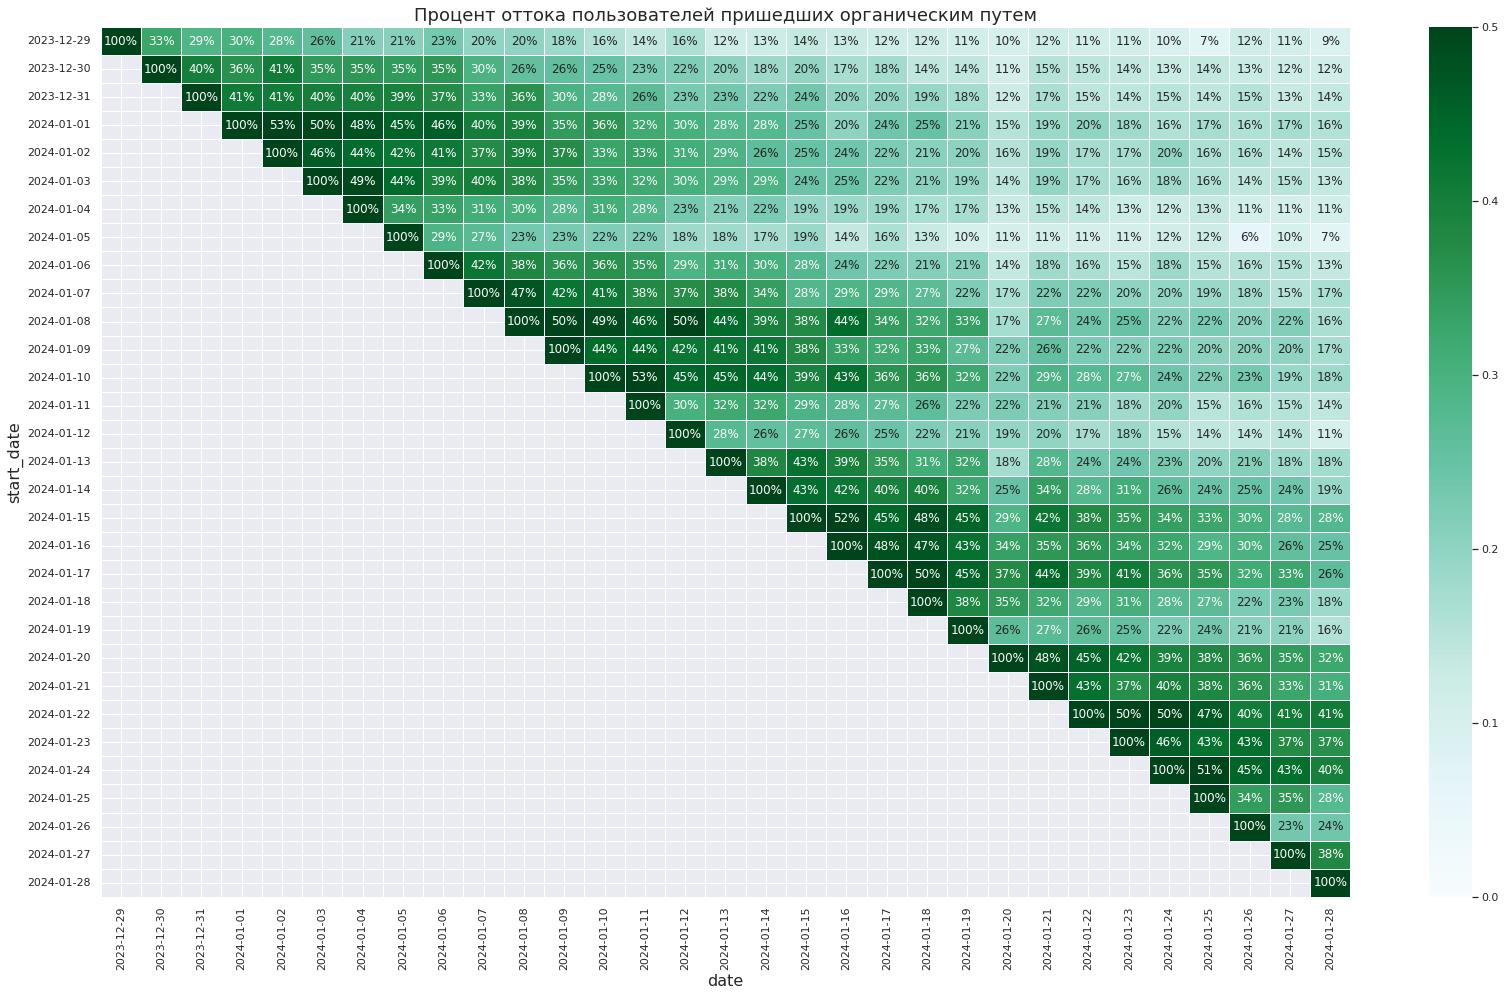

In [17]:
#построим график оттока пользователей через органику

plt.figure(figsize = (28,16))
plt.rcParams['axes.titlesize'] = 18
plt.xlabel('xlabel', fontsize=16)
plt.ylabel('ylabel', fontsize=16)
plt.title('Процент оттока пользователей пришедших органическим путем')
sns.set(font='sans-serif')
sns.heatmap(df_percentage_organic, annot=True, fmt = '.0%', vmin=0, vmax=0.5, cmap='BuGn', linewidths = 1, linecolor = "white")

## Выводы по органическому трафику:
1. В 7 когортах процент оттока c 1 на 2 день составил менее 50%, в 18 когортах процент оттока составил менее 40%.
2. В целом у данных пользователей нет сильных просадок, к концу рассматриваемого периоа, процент оттока ниже чем у пользователей, пришедших через рекламу.
3. График оттока более плавный.

## Общие выводы:
Проанализировав ретеншен пользователей, пришедших в приложение через платные трафики и через органику, можно сделать вывод, что харакер использования приложения между ними разный, пользователи, пришедшие черех орагинку более лояльны, склонны к более частому пользованию приложения, процент оттока на конец рассматриваемого периода ниже. Необходимо проанализировать пользователей пришедших через рекламу, которые имели тенденцию к частому пользованию приложением, узнать плюсы и минусы приложения, в дальнейшем проводить рекламные компании ориентируясь на данных пользователей.